In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, silhouette_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('house_prices_selection.csv')
print(df.shape)
df.head()

(1460, 32)


,EVI,ZoningScore,MSZoning_RL,LotConfig_CulDSac,LandContour_HLS,LotShape_IR2,Condition1_Norm,Condition1_Feedr,LotShape_Reg,MSZoning_RM,...,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,GrLivArea,TotalBsmtSF,1stFlrSF,BsmtQual,CentralAir,Foundation
0,0.437530,0.835044,True,False,False,False,True,False,True,False,...,7,2003,2003,196.0,1710,856,856,Gd,Y,PConc
1,0.364741,0.835044,True,False,False,False,False,True,True,False,...,6,1976,1976,0.0,1262,1262,1262,Gd,Y,CBlock
2,0.411955,0.835044,True,False,False,False,True,False,False,False,...,7,2001,2002,162.0,1786,920,920,Gd,Y,PConc
3,0.394783,0.835044,True,False,False,False,True,False,False,False,...,7,1915,1970,0.0,1717,756,961,TA,Y,BrkTil
4,0.399533,0.835044,True,False,False,False,True,False,False,False,...,8,2000,2000,350.0,2198,1145,1145,Gd,Y,PConc


In [9]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
boolean_features = df.select_dtypes(include=['bool']).columns.tolist()

if 'SalePrice' in numerical_features:
    numerical_features.remove('SalePrice')

for cols in boolean_features:
    df[cols] = df[cols].astype(int)
numerical_features.extend(boolean_features)

In [10]:
print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (26): ['EVI', 'ZoningScore', 'MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [11]:
X = df.drop('SalePrice', axis=1)
Y = df['SalePrice']
print(f"Features shape: {X.shape}")
print(f"Target shape: {Y.shape}")

Features shape: (1460, 31)
Target shape: (1460,)


In [12]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [16]:
X_preprocessed = preprocessor.fit_transform(X)

K=2: Inertia=33693.01, Silhouette=0.1760
K=3: Inertia=29762.48, Silhouette=0.1786
K=4: Inertia=28018.55, Silhouette=0.1533
K=5: Inertia=26572.85, Silhouette=0.1554
K=6: Inertia=25046.88, Silhouette=0.1697
K=7: Inertia=23835.45, Silhouette=0.1520
K=8: Inertia=22846.05, Silhouette=0.1701
K=9: Inertia=21857.97, Silhouette=0.1760
K=10: Inertia=20791.14, Silhouette=0.1820
K=11: Inertia=20269.75, Silhouette=0.1628
K=12: Inertia=19707.41, Silhouette=0.1448
K=13: Inertia=18911.97, Silhouette=0.1408
K=14: Inertia=18465.31, Silhouette=0.1459
K=15: Inertia=18330.58, Silhouette=0.1486
K=16: Inertia=17905.36, Silhouette=0.1339
K=17: Inertia=17639.69, Silhouette=0.1276
K=18: Inertia=17314.16, Silhouette=0.1214
K=19: Inertia=17172.40, Silhouette=0.1187


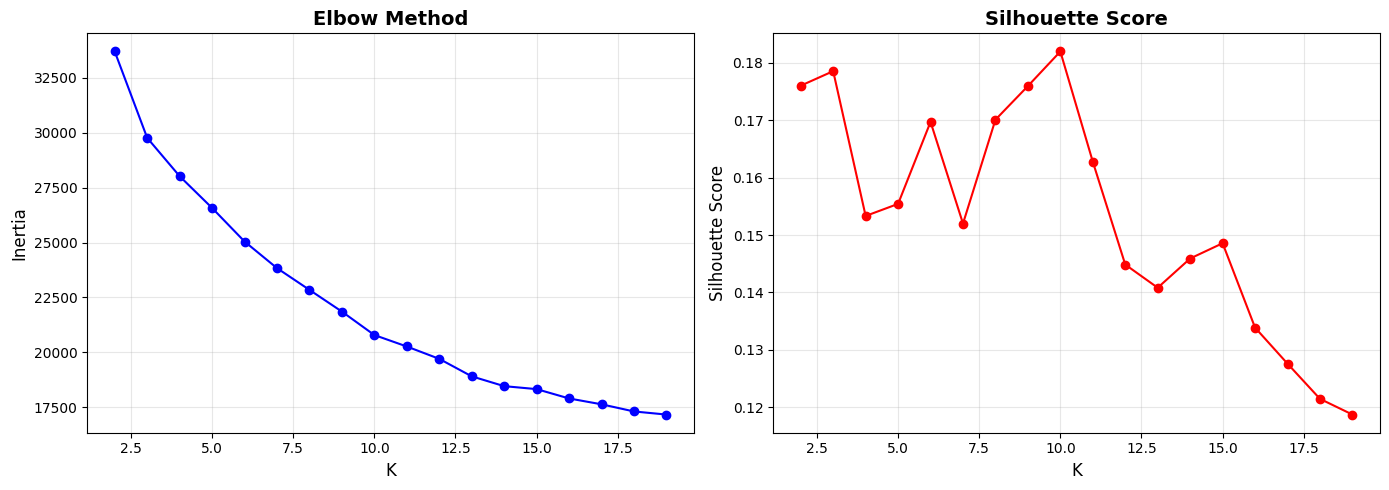

In [18]:
inertia_values = []
silhouette_scores = []
K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_preprocessed)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_preprocessed, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertia_values, 'bo-')
axes[0].set_xlabel('K', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('K', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

I'll consider 4 clusters.

In [20]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_preprocessed)

df['ClusterLabel'] = cluster_labels

In [21]:
df_classification = df.drop('SalePrice', axis=1)
X_class = df_classification.drop('ClusterLabel', axis=1)
Y_class = df_classification['ClusterLabel']

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split( X_class, Y_class, test_size=0.2, random_state=42, stratify=Y_class)

print(f"\nTrain set: {X_train.shape}")
print(f"\n{Y_train.value_counts().sort_index()}")
print(f"\nTest set: {X_test.shape}")
print(f"\n{Y_test.value_counts().sort_index()}")


Train set: (1168, 31)

ClusterLabel
0    180
1    188
2    323
3    477
Name: count, dtype: int64

Test set: (292, 31)

ClusterLabel
0     45
1     47
2     81
3    119
Name: count, dtype: int64


In [25]:
df_classification.to_csv("cluster_label_house_prices.csv", index=False)

In [26]:
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [28]:
clf_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['EVI', 'ZoningScore',
                                                   'MSZoning_RL',
                                                   'LotConfig_CulDSac',
                                                   'LandContour_HLS',
                                                   'LotShape_IR2',
                                                   'Condition1_Norm',
                                                   'Condition1_Feedr',
                                                   'LotShape_Reg',
                                                   'MSZoning_RM',
                                                   'Price_per_m^2', 'PDI',
                                                   'LotFrontage...
                                                   'GarageArea', 'OverallQual',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'GrLivArea',
                                                   'TotalBsmtSF', '1stFlrSF']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['KitchenQual', 'PavedDrive',
                                                   'BsmtQual', 'CentralAir',
                                                   'Foundation'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [29]:
y_pred = clf_pipeline.predict(X_test)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

Confusion Matrix:
 [[ 36   0   6   3]
 [  0  47   0   0]
 [  9   0  69   3]
 [  1   0   8 110]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79        45
           1       1.00      1.00      1.00        47
           2       0.83      0.85      0.84        81
           3       0.95      0.92      0.94       119

    accuracy                           0.90       292
   macro avg       0.89      0.89      0.89       292
weighted avg       0.90      0.90      0.90       292



24-Nov

In [33]:
X = df.drop("ClusterLabel", axis=1)
y = df["ClusterLabel"]

In [34]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [46]:
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_cols)
])

In [47]:
models = {
    "LogisticRegression": Pipeline([("preprocess", preprocess),
                                    ("model", LogisticRegression(max_iter=2000))]),
    "DecisionTree": Pipeline([("preprocess", preprocess),
                              ("model", DecisionTreeClassifier(random_state=42))]),
    "KNN": Pipeline([("preprocess", preprocess),
                     ("model", KNeighborsClassifier())]),
    "RandomForest": Pipeline([("preprocess", preprocess),
                              ("model", RandomForestClassifier(random_state=42, n_estimators=100))]),
    "GradientBoosting": Pipeline([("preprocess", preprocess),
                                  ("model", GradientBoostingClassifier(random_state=42, n_estimators=100))]),
    "SVM": Pipeline([("preprocess", preprocess),
                     ("model", SVC(probability=True, random_state=42))])
}

 Ensemble 1: Logistic Regression + Decision Tree + KNN (hard voting)

In [48]:
voting1 = VotingClassifier(
    estimators=[
        ("lr", models["LogisticRegression"]),
        ("dt", models["DecisionTree"]),
        ("knn", models["KNN"])
    ],
    voting="hard"
)

Ensemble 2: Random Forest + Gradient Boosting + SVM (soft voting)

In [49]:
voting2 = VotingClassifier(
    estimators=[
        ("rf", models["RandomForest"]),
        ("gb", models["GradientBoosting"]),
        ("svm", models["SVM"])
    ],
    voting="soft"
)

In [50]:
print("=== Individual Model CV Accuracy ===")
for name, pipe in models.items():
    score = cross_val_score(pipe, X, y, cv=5, scoring="accuracy")
    print(f"{name}: {score.mean():.3f}")

print("\n=== VotingClassifier CV Accuracy ===")
score_v1 = cross_val_score(voting1, X, y, cv=5, scoring="accuracy")
print(f"VotingClassifier LR + DT + KNN (hard): {score_v1.mean():.3f}")

score_v2 = cross_val_score(voting2, X, y, cv=5, scoring="accuracy")
print(f"VotingClassifier RF + GB + SVM (soft): {score_v2.mean():.3f}")

=== Individual Model CV Accuracy ===
LogisticRegression: 0.982
DecisionTree: 0.910
KNN: 0.931
RandomForest: 0.953
GradientBoosting: 0.958
SVM: 0.973

=== VotingClassifier CV Accuracy ===
VotingClassifier LR + DT + KNN (hard): 0.966
VotingClassifier RF + GB + SVM (soft): 0.968


Logistic Regression performed the best individually (0.982)

Decision Tree and KNN are slightly lower, showing some variance in capturing patterns individually.

Random Forest, Gradient Boosting, and SVM are still strong.

Both ensembles perform slightly lower than the top individual model (Logistic Regression 0.982).

LR + DT + KNN hard voting: 0.966 → combines diverse models, but hard voting sometimes reduces performance if one strong model dominates (LR is very strong).

RF + GB + SVM soft voting: 0.968 → soft voting leverages probabilities and slightly outperforms the hard voting ensemble.

**26 Nov**

Stacking: DT + KNN → Logistic Regression

In [52]:
stack1 = StackingClassifier(
    estimators=[
        ("dt", DecisionTreeClassifier(random_state=42)),
        ("knn", KNeighborsClassifier())
    ],
    final_estimator=LogisticRegression(max_iter=2000)
)

pipeline_stack1 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack1)
])

Stacking: RF + GB + SVM → Logistic Regression

In [53]:
stack2 = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(random_state=42)),
        ("gb", GradientBoostingClassifier(random_state=42)),
        ("svm", SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=2000)
)

pipeline_stack2 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack2)
])

Stacking:LR+RF+KNN -> GradBoost

In [54]:
stack3 = StackingClassifier(
    estimators=[
        ("lr", LogisticRegression(max_iter=2000)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("knn", KNeighborsClassifier())
    ],
    final_estimator=GradientBoostingClassifier(random_state=42)
)

pipeline_stack3 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack3)
])

In [55]:
scores_stack1 = cross_val_score(pipeline_stack1, X, y, cv=5, scoring="accuracy")
print(f"Stacking DT + KNN → LogisticRegression: {scores_stack1.mean():.3f}")

scores_stack2 = cross_val_score(pipeline_stack2, X, y, cv=5, scoring="accuracy")
print(f"Stacking RF + GB + SVM → LogisticRegression: {scores_stack2.mean():.3f}")

scores_stack3 = cross_val_score(pipeline_stack3, X, y, cv=5, scoring="accuracy")
print(f"Stacking LR + RF + KNN → GB: {scores_stack3.mean():.3f}")

Stacking DT + KNN → LogisticRegression: 0.940
Stacking RF + GB + SVM → LogisticRegression: 0.973
Stacking LR + RF + KNN → GB: 0.979


DT + KNN → Logistic Regression. Base models weak; meta-model linear → lowest stack performance.


RF + GB + SVM → Logistic Regression. Strong base models; meta-model combines well.


LR + RF + KNN → Gradient Boosting. Best overall; diverse base + powerful meta-model captures complex interactions.

Still, logistic regression remains best...